In [7]:
from sklearn.datasets import load_iris
data = load_iris()

In [29]:
import pandas as pd
df = pd.DataFrame({data['feature_names'][0]: data['data'][:,0],
    data['feature_names'][1]: data['data'][:,1],
    data['feature_names'][2]: data['data'][:,2],
    data['feature_names'][3]: data['data'][:,3],
    "label": data['target']
})

In [31]:
# Checking the dataframe
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [32]:
# check the count of the labels
df['label'].value_counts()

label
0    50
1    50
2    50
Name: count, dtype: int64

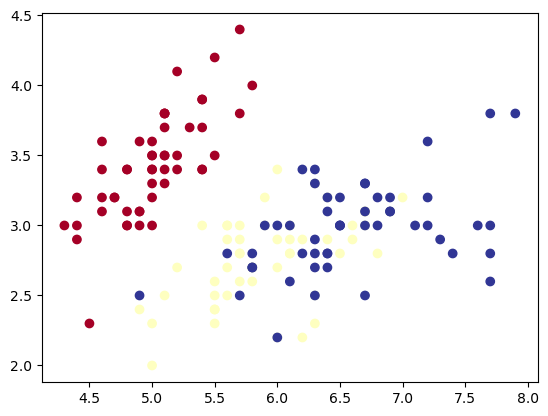

In [42]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=df.iloc[:, 0],
            y=df.iloc[:, 1], 
            c=df['label'], 
            cmap=plt.cm.RdYlBu);

In [62]:
X = data['data']
y = data['target']

In [56]:
X.shape

(150, 4)

In [57]:
y.shape

(150,)

#### Turing the data to tensor

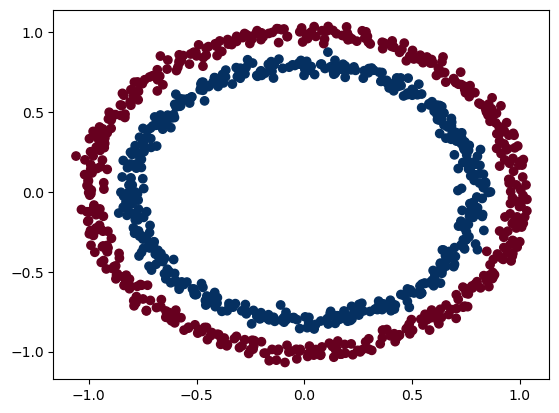

In [201]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [202]:
import torch

In [203]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [204]:
print(X.shape)
print(y.shape)

torch.Size([1000, 2])
torch.Size([1000])


In [205]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#### Making a model

In [206]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [207]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [220]:
class CircleClassifierOne(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [221]:
modelOne = CircleClassifierOne().to(device)
modelOne

CircleClassifierOne(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [222]:
# loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(modelOne.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [223]:
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [224]:
y_logits = modelOne(X_test.to(device))[:5]
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5042],
        [0.5052],
        [0.5032],
        [0.5043],
        [0.5105]], grad_fn=<SigmoidBackward0>)

In [225]:
torch.manual_seed(42)
epochs = 100
for epoch in range(epochs):
    # set model in training mode
    modelOne.train()
    y_logits = modelOne(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(torch.sigmoid(y_logits),y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #test
    modelOne.eval()
    with torch.inference_mode():
        test_logits = modelOne(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(
            torch.sigmoid(test_logits),y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        
    

Epoch: 0 | Loss: 0.72469, Accuracy: 50.00% | Test loss: 0.72464, Test acc: 50.00%
Epoch: 10 | Loss: 0.72339, Accuracy: 50.62% | Test loss: 0.72332, Test acc: 49.50%
Epoch: 20 | Loss: 0.72213, Accuracy: 50.00% | Test loss: 0.72205, Test acc: 50.00%
Epoch: 30 | Loss: 0.72092, Accuracy: 50.00% | Test loss: 0.72082, Test acc: 50.00%
Epoch: 40 | Loss: 0.71974, Accuracy: 50.00% | Test loss: 0.71963, Test acc: 50.00%
Epoch: 50 | Loss: 0.71858, Accuracy: 50.00% | Test loss: 0.71847, Test acc: 50.00%
Epoch: 60 | Loss: 0.71746, Accuracy: 50.00% | Test loss: 0.71734, Test acc: 50.00%
Epoch: 70 | Loss: 0.71638, Accuracy: 50.00% | Test loss: 0.71625, Test acc: 50.00%
Epoch: 80 | Loss: 0.71535, Accuracy: 50.00% | Test loss: 0.71520, Test acc: 50.00%
Epoch: 90 | Loss: 0.71435, Accuracy: 50.00% | Test loss: 0.71419, Test acc: 50.00%


In [226]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = modelOne(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    modelOne.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = modelOne(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70967, Accuracy: 50.00% | Test Loss: 0.70847, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69087, Accuracy: 51.38% | Test Loss: 0.69064, Test Accuracy: 53.00%
Epoch: 200 | Loss: 0.68935, Accuracy: 53.00% | Test Loss: 0.68880, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68735, Accuracy: 52.62% | Test Loss: 0.68641, Test Accuracy: 56.50%
Epoch: 400 | Loss: 0.68444, Accuracy: 53.00% | Test Loss: 0.68294, Test Accuracy: 56.00%
Epoch: 500 | Loss: 0.67976, Accuracy: 52.88% | Test Loss: 0.67779, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67321, Accuracy: 54.87% | Test Loss: 0.67049, Test Accuracy: 57.00%
Epoch: 700 | Loss: 0.66347, Accuracy: 58.25% | Test Loss: 0.65971, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.64536, Accuracy: 67.62% | Test Loss: 0.64160, Test Accuracy: 73.50%
Epoch: 900 | Loss: 0.61078, Accuracy: 79.00% | Test Loss: 0.61093, Test Accuracy: 81.00%
